# Numba - CPU parallelisation

The choice of whether to use parallel CPU target for any given algorithm depends on a number of factors.  

This notebook illustrates how the 'size' and 'shape' of a given dataset may be a factor, for a simple algorithm which is equivalent to the default implementation of  [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

More details on numba's parallelisation features are given in the excellent [numba docs](http://numba.pydata.org/numba-doc/0.36.1/user/parallel.html)

In [1]:
import numpy as np
import pandas as pd
from numba import njit, prange
from pytest import approx
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

Note regding the following algorithms:

- **standard**: uses single threaded CPU target
- **standard_parallel**: uses parallel CPU target and numba.prange explicit parallel loop

In [2]:
@njit(parallel=False)
def standard(A):
    """
    Standardise data by removing the mean and scaling to unit variance,
    equivalent to sklearn StandardScaler.
    """
    n = A.shape[1]
    res = np.empty_like(A, dtype=np.float64)

    for i in range(n):
        data_i = A[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

In [3]:
@njit(parallel=True)
def standard_parallel(A):
    """
    Standardise data by removing the mean and scaling to unit variance,
    equivalent to sklearn StandardScaler.
    
    Uses explicit parallel loop; may offer improved performance in some
    cases.
    """
    n = A.shape[1]
    res = np.empty_like(A, dtype=np.float64)

    for i in prange(n):
        data_i = A[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

We're going to use the IRIS dataset (150 rows x 4 columns) for this test.

In [4]:
A = load_iris().data

In [5]:
expected = StandardScaler().fit_transform(A)

In [6]:
output = standard(A)

In [7]:
np.allclose(output, expected)

True

In [8]:
output_parallel = standard_parallel(A)

In [9]:
np.allclose(output_parallel, expected)

True

In [10]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

Firstly, we're going to tile the data 'horizontally' so that we keep the same number of rows but add successively more columns.

In [11]:
res = []
multiples = range(1, 42, 5)

for idx, i in enumerate(multiples):
    data = np.tile(A, i)
    
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard(data)
    o_3 = %timeit -o -q standard_parallel(data)
    
    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 9 complete (150, 4)
2 of 9 complete (150, 24)
3 of 9 complete (150, 44)
4 of 9 complete (150, 64)
5 of 9 complete (150, 84)
6 of 9 complete (150, 104)
7 of 9 complete (150, 124)
8 of 9 complete (150, 144)
9 of 9 complete (150, 164)


In [12]:
df = pd.DataFrame(res, columns = ['num_cols', 'sklearn', 'numba CPU', 'numba CPU parallel'])

In [13]:
df = df.set_index('num_cols')
df = df.apply(lambda x: 1000 * x)

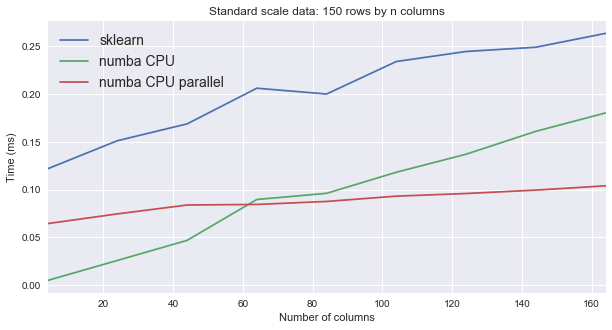

In [14]:
ax = df.plot()
ax.set_title('Standard scale data: 150 rows by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

In [15]:
df.style.apply(highlight_min, axis=1)

,sklearn,numba CPU,numba CPU parallel
num_cols,,,
4,0.121786,0.00475795,0.0643363
24,0.151202,0.0257044,0.0745132
44,0.168868,0.0467578,0.0838214
64,0.206255,0.0896142,0.0844222
84,0.200158,0.0960841,0.0875621
104,0.234245,0.11817,0.0931101
124,0.244757,0.137082,0.0958816
144,0.249212,0.161065,0.0994426
164,0.263761,0.180338,0.103951


In the above results, observe the crossing point where CPU parallel is (and remains) the fastest computational strategy.

Furthermore, observe its relative insensitivity to number of columns.

Next, we're going to repeat the experiment but this time tiling the data 'vertically' so that we add successively more rows.

In [17]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(A.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard(data)
    o_3 = %timeit -o -q standard_parallel(data)
    
    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 9 complete (150, 4)
2 of 9 complete (900, 4)
3 of 9 complete (1650, 4)
4 of 9 complete (2400, 4)
5 of 9 complete (3150, 4)
6 of 9 complete (3900, 4)
7 of 9 complete (4650, 4)
8 of 9 complete (5400, 4)
9 of 9 complete (6150, 4)


In [18]:
df = pd.DataFrame(res, columns = ['num_rows', 'sklearn', 'numba CPU', 'numba CPU parallel'])

In [19]:
df = df.set_index('num_rows')
df = df.apply(lambda x: 1000 * x)

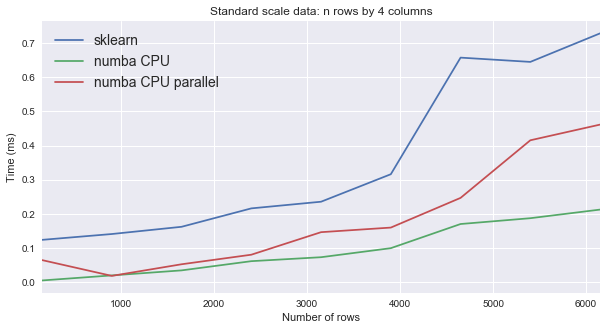

In [20]:
ax = df.plot()
ax.set_title('Standard scale data: n rows by 4 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

In [21]:
df.style.apply(highlight_min, axis=1)

,sklearn,numba CPU,numba CPU parallel
num_rows,,,
150,0.123694,0.00479796,0.0644024
900,0.140786,0.0195348,0.0181729
1650,0.161948,0.0342706,0.0522027
2400,0.2159,0.0612522,0.0801998
3150,0.235414,0.0728591,0.146206
3900,0.315953,0.0993358,0.159655
4650,0.657485,0.170097,0.246642
5400,0.644944,0.18712,0.415349
6150,0.728555,0.212345,0.461296


In this case, observe that CPU parallel is almost never optimal.

Furthermore, observe its sensitivity to number of rows.